# Exploratory Analysis

---

This notebook outlines the process for exploring the Zillow property data used in this project.

---

## Importing the Required Modules

Below we import all the modules needed to run this notebook. (Note on other user modules needed)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from univariate_analysis import get_hist, get_box

from env import username, password, hostname

## Acquire Data

Here we define all our acquisition and preparation functions created in the acquire and prepare notebook.

In [2]:
def get_db_url(database_name, username = username, password = password, hostname = hostname):
    return f'mysql+pymysql://{username}:{password}@{hostname}/{database_name}'

def get_zillow_sql():
    return """
        SELECT
            bedroomcnt,
            bathroomcnt,
            calculatedfinishedsquarefeet,
            taxvaluedollarcnt,
            yearbuilt,
            fips,
            numberofstories,
            basementsqft,
            fireplacecnt,
            heatingorsystemdesc,
            roomcnt,
            garagetotalsqft,
            hashottuborspa,
            poolcnt,
            poolsizesum,
            yardbuildingsqft17
        FROM properties_2017
        JOIN propertylandusetype
            ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
            AND (propertylandusetype.propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential'))
        LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
        JOIN predictions_2017 ON properties_2017.parcelid = predictions_2017.parcelid
            AND predictions_2017.transactiondate LIKE '2017%%';
        """

def get_zillow_data(use_cache = True):
    # If the file is cached, read from the .csv file
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cache')
        return pd.read_csv('zillow.csv')
    
    # Otherwise read from the mysql database
    else:
        print('Reading from database')
        df = pd.read_sql(get_zillow_sql(), get_db_url('zillow'))
        df.to_csv('zillow.csv', index = False)
        return df
    
def prepare_zillow_data(df):
    columns = ['calculatedfinishedsquarefeet']

    df = remove_outliers(df, 1.5, columns)
    
    missing_target = df.taxvaluedollarcnt.isnull()
    df = df[~missing_target]
    
    missing_yearbuilt = df.yearbuilt.isnull()
    df = df[~missing_yearbuilt]
    
    df.yearbuilt.fillna(df.yearbuilt.mode()[0], inplace = True)
    df.basementsqft.fillna(0, inplace = True)
    df.fireplacecnt.fillna(0, inplace = True)
    df.hashottuborspa.fillna(0, inplace = True)
    df.poolcnt.fillna(0, inplace = True)
    
    df = df.drop(columns = 'numberofstories')
    df = df.drop(columns = 'heatingorsystemdesc')
    df = df.drop(columns = 'garagetotalsqft')
    df = df.drop(columns = 'poolsizesum')
    df = df.drop(columns = 'yardbuildingsqft17')
    df = df.drop(columns = 'roomcnt')
    
    df.yearbuilt = df.yearbuilt.astype('int')
    df.bedroomcnt = df.bedroomcnt.astype('int')
    df.fips = df.fips.astype('int')
    df.fireplacecnt = df.fireplacecnt.astype('int')
    df.hashottuborspa = df.hashottuborspa.astype('int')
    df.poolcnt = df.poolcnt.astype('int')

    # Rename the columns for readability
    df = df.rename(columns = {
        'bedroomcnt' : 'bedroom_count',
        'bathroomcnt' : 'bathroom_count',
        'calculatedfinishedsquarefeet' : 'square_feet',
        'taxvaluedollarcnt' : 'property_tax_assessed_values',
        'yearbuilt' : 'year_built',
        'fips' : 'fed_code',
        'basementsqft' : 'basement_square_feet',
        'fireplacecnt' : 'fireplace_count',
        'hashottuborspa' : 'has_hot_tub',
        'poolcnt' : 'has_pool'
    })
    
    return df

def remove_outliers(df, k, col_list):
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [3]:
properties = prepare_zillow_data(get_zillow_data())
properties.info()

Using cache
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50042 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroom_count                 50042 non-null  int64  
 1   bathroom_count                50042 non-null  float64
 2   square_feet                   50042 non-null  float64
 3   property_tax_assessed_values  50042 non-null  float64
 4   year_built                    50042 non-null  int64  
 5   fed_code                      50042 non-null  int64  
 6   basement_square_feet          50042 non-null  float64
 7   fireplace_count               50042 non-null  int64  
 8   has_hot_tub                   50042 non-null  int64  
 9   has_pool                      50042 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 4.2 MB


## Split Data

Now before we proceed we must split the data. Note that it is not necessary to split the data until we get to bi-variate analysis, but we'll do it now just to be safe.

In [4]:
def split_data(df, random_seed = 24, stratify = None):
    test_split = 0.2
    train_validate_split = 0.3

    train_validate, test = train_test_split(
        df,
        test_size = test_split,
        random_state = random_seed,
        stratify = stratify if not stratify else df[stratify]
    )
    train, validate = train_test_split(
        train_validate,
        test_size = train_validate_split,
        random_state = random_seed,
        stratify = stratify if not stratify else train_validate[stratify]
    )
    return train, validate, test

In [5]:
train, validate, test = split_data(properties)
train.shape, validate.shape, test.shape

((28023, 10), (12010, 10), (10009, 10))

## Univariate Analysis

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28023 entries, 39278 to 30295
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroom_count                 28023 non-null  int64  
 1   bathroom_count                28023 non-null  float64
 2   square_feet                   28023 non-null  float64
 3   property_tax_assessed_values  28023 non-null  float64
 4   year_built                    28023 non-null  int64  
 5   fed_code                      28023 non-null  int64  
 6   basement_square_feet          28023 non-null  float64
 7   fireplace_count               28023 non-null  int64  
 8   has_hot_tub                   28023 non-null  int64  
 9   has_pool                      28023 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 2.4 MB


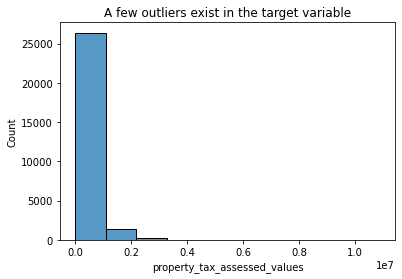

In [7]:
sns.histplot(train.property_tax_assessed_values, bins = 10)
plt.title('A few outliers exist in the target variable');

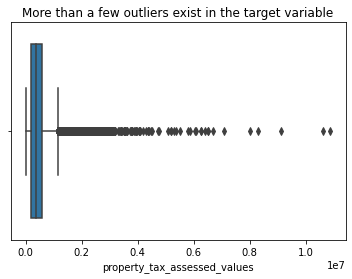

In [8]:
sns.boxplot(data = train, x = 'property_tax_assessed_values')
plt.title('More than a few outliers exist in the target variable');

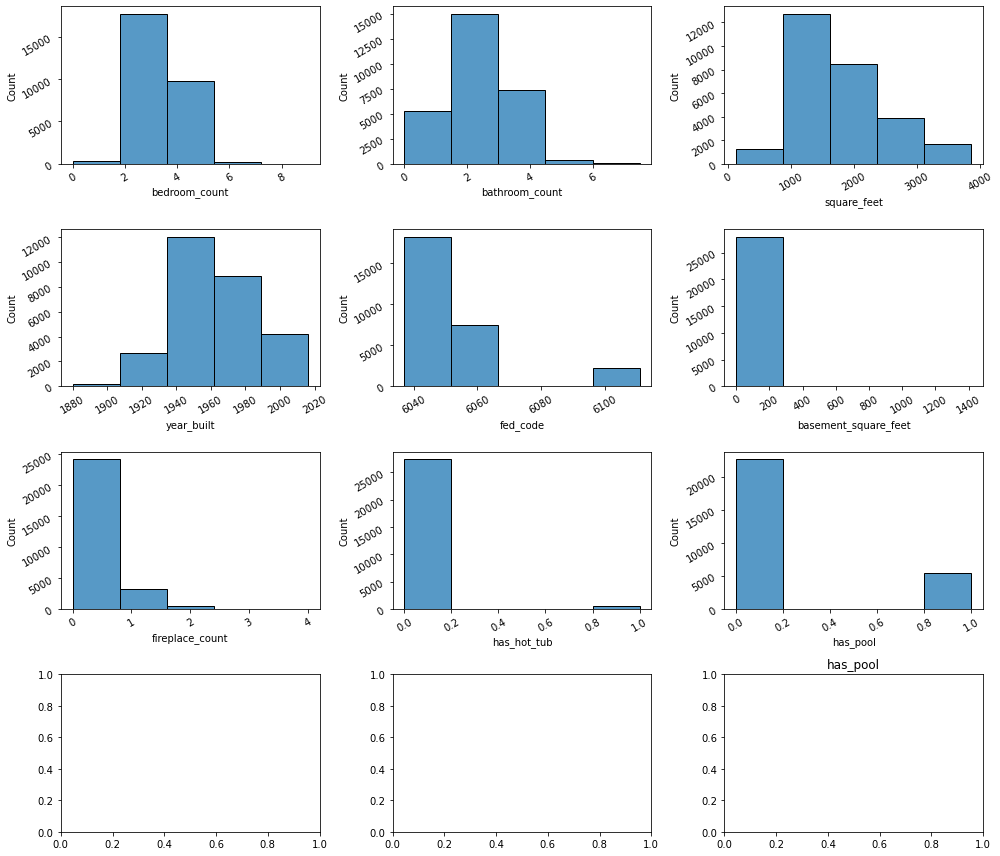

In [9]:
get_hist(train, train.drop(columns = 'property_tax_assessed_values').columns)

- bedroom_count, bathroom_count, square_feet, year_built are all normally distributed.
- most properties at fed code 6040.
- no basement, fireplace, hot tub, pool are common.

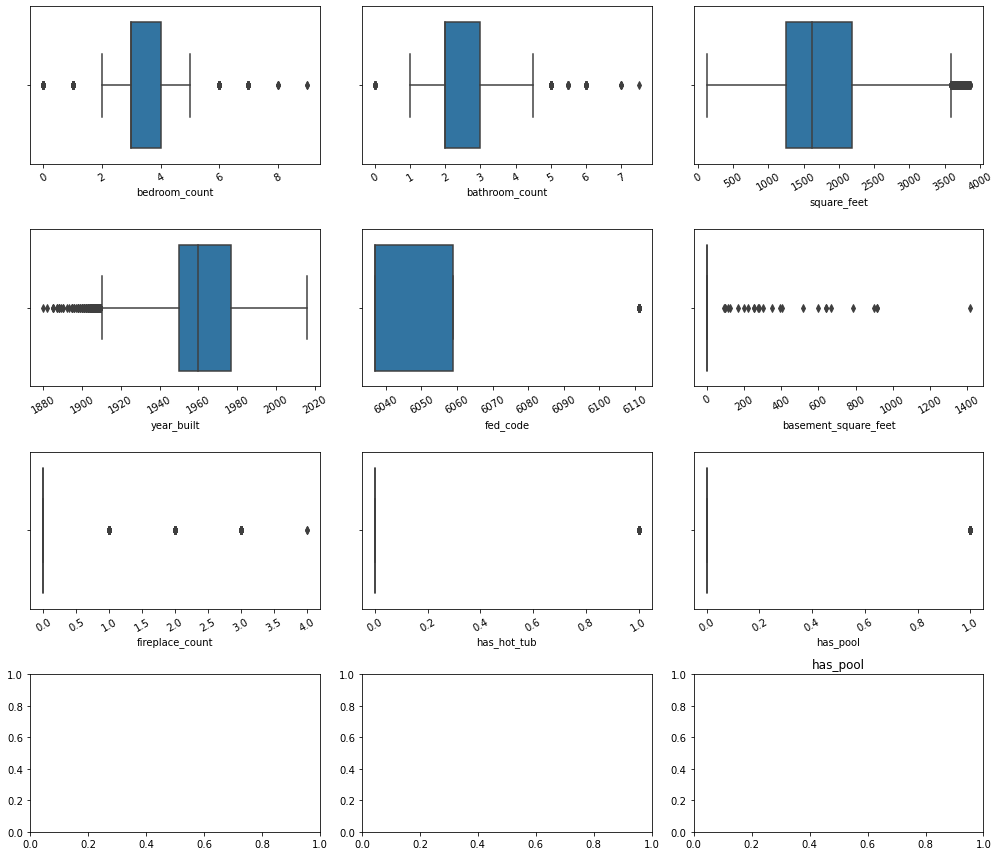

In [10]:
get_box(train, train.drop(columns = 'property_tax_assessed_values').columns)

There are some outliers in the data but not enough to be concerning.

## Bivariate Analysis

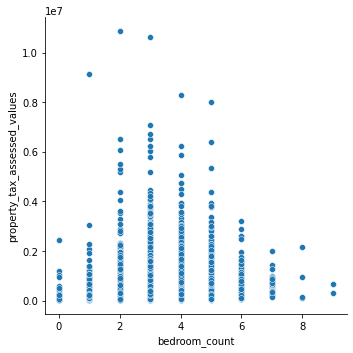

In [11]:
# Bedroom count
sns.relplot(data = train, x = 'bedroom_count', y = 'property_tax_assessed_values');

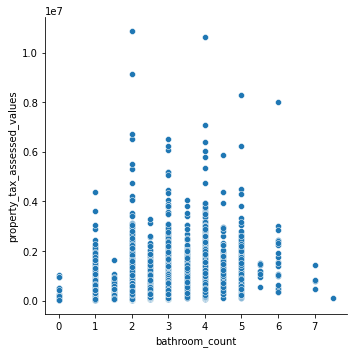

In [12]:
# Bathroom count
sns.relplot(data = train, x = 'bathroom_count', y = 'property_tax_assessed_values');

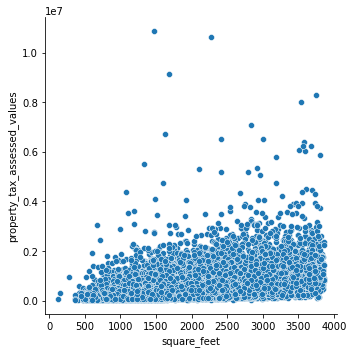

In [13]:
# Square footage
sns.relplot(data = train, x = 'square_feet', y = 'property_tax_assessed_values');

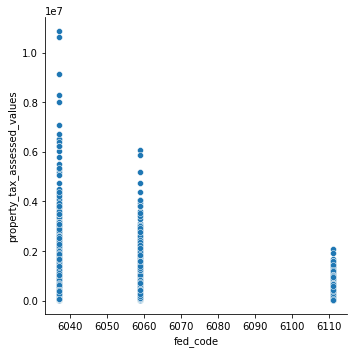

In [14]:
# location
sns.relplot(data = train, x = 'fed_code', y = 'property_tax_assessed_values');

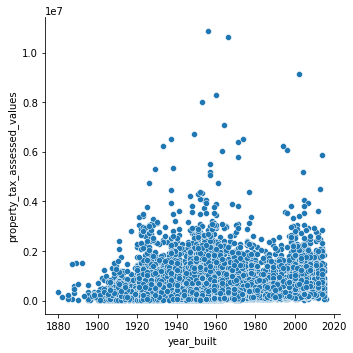

In [15]:
# year built
sns.relplot(data = train, x = 'year_built', y = 'property_tax_assessed_values');

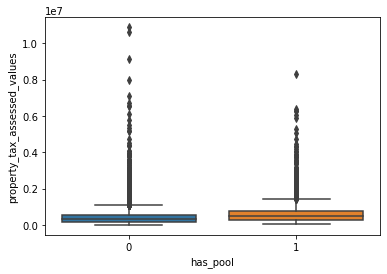

In [16]:
# Pool
sns.boxplot(data = train, x = 'has_pool', y = 'property_tax_assessed_values');

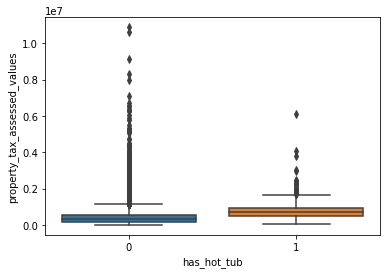

In [17]:
# hot tub
sns.boxplot(data = train, x = 'has_hot_tub', y = 'property_tax_assessed_values');

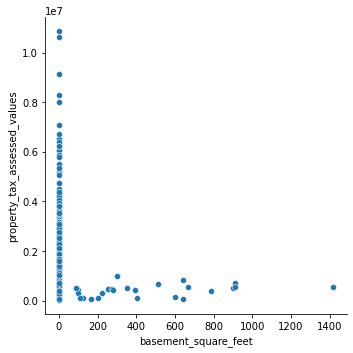

In [18]:
# basement
sns.relplot(data = train, x = 'basement_square_feet', y = 'property_tax_assessed_values');

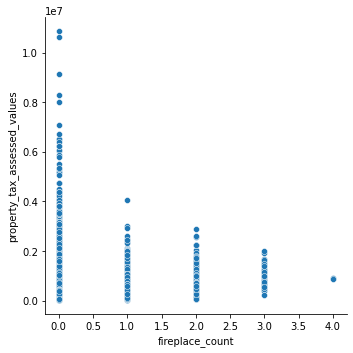

In [19]:
# fireplace
sns.relplot(data = train, x = 'fireplace_count', y = 'property_tax_assessed_values');

Year built, square footage, and location likely have the greatest influence on a property's value.

## Multivariate Analysis

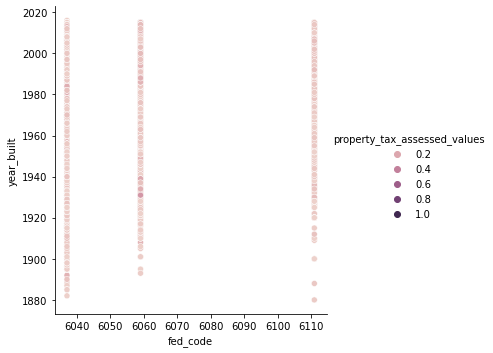

In [20]:
sns.relplot(data = train, x = 'fed_code', y = 'year_built', hue = 'property_tax_assessed_values');

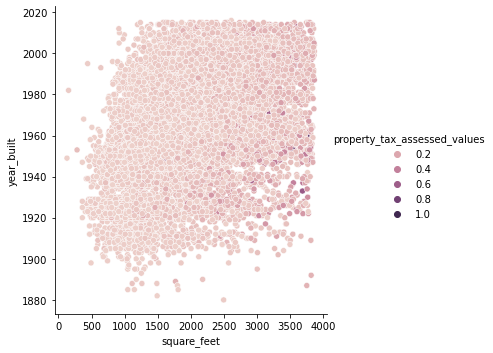

In [21]:
sns.relplot(data = train, x = 'square_feet', y = 'year_built', hue = 'property_tax_assessed_values');

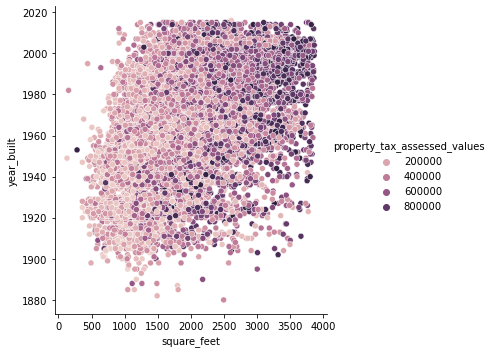

In [22]:
mask = train.property_tax_assessed_values < 1_000_000
sns.relplot(data = train[mask], x = 'square_feet', y = 'year_built', hue = 'property_tax_assessed_values');

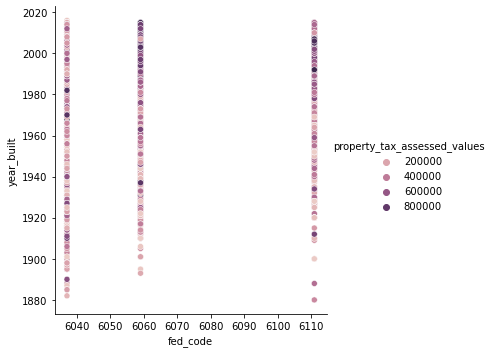

In [23]:
sns.relplot(data = train[mask], x = 'fed_code', y = 'year_built', hue = 'property_tax_assessed_values');

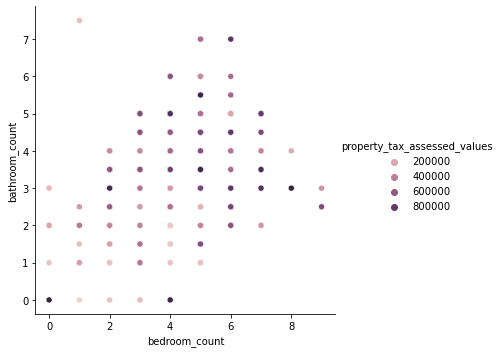

In [24]:
sns.relplot(data = train[mask], x = 'bedroom_count', y = 'bathroom_count', hue = 'property_tax_assessed_values');

## Hypothesis Testing

In [36]:
from stats_util import *

$H_a$: The square footage of a property correlates with the value of the property.

In [38]:
correlation_test(train.square_feet, train.property_tax_assessed_values)

r = 0.4606
p = 0.0000

Reject H0


$H_a$: The year a property was built correlates with the value of the property.

In [39]:
correlation_test(train.year_built, train.property_tax_assessed_values)

r = 0.1428
p = 0.0000

Reject H0


$H_a$: The number of bedrooms a property has correlates with the value of the property.

In [40]:
correlation_test(train.bedroom_count, train.property_tax_assessed_values)

r = 0.1785
p = 0.0000

Reject H0


$H_a$: The number of bathrooms a property has correlates with the value of the property.

In [41]:
correlation_test(train.bathroom_count, train.property_tax_assessed_values)

r = 0.4023
p = 0.0000

Reject H0


## Conclusions

We'll move forward with square_feet, bedroom_count, bathroom_count, year_built